In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Create initial datasets

### Setup input/output

In [2]:
# set base directory
baseDIR = '/mnt/d'
# set input directory
inDIR = 'TBNG/data/veg/PVSAGE'
# set input file
inXLSX = 'PVSAGEmulti-year_Herb_9November2021SD.xlsx'

### Load data

In [3]:
# create an Excel file object for investigating contents
nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))

# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['metadata',
 'sentek tube installation notes',
 'sentek notes',
 'grass & forb heights',
 'basal cover',
 'phenology',
 'aerial cover',
 'herbaceous density',
 '2017 FQ baseline fxnal group',
 'forage quality',
 'baseline fxnal group FQ 2017',
 'pin frame',
 'pin frame calibration',
 'pinframe calibration clipping',
 'shrub volumes',
 'shrub densities',
 'shrub leaders',
 'shrub plot notes',
 'light reading',
 'light reading times']

In [4]:
# Create the desired dataframes by parsing the individual sheets
df_pvs_bm = nex_xlsx.parse(sheet_name='pinframe calibration clipping', header=0)
df_pvs_pf = nex_xlsx.parse(sheet_name='pin frame calibration', header=0)

# Biomass dataset

#### Clean up dates

In [5]:
# create a mask to identify all values that are 'date-like'
dates_bm_mask = df_pvs_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# summarize to find all unique values in the 'Date' column for each year
dates_yrly_bm = pd.DataFrame(df_pvs_bm.groupby('Year')['Date'].unique()).explode('Date')
# create a mask of 'date-like' values from the unique values pulled for each year
dates_yrly_bm_mask = dates_yrly_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# create a Series of the 'date-like' unique values
dates_yrly_bm_good = dates_yrly_bm['Date'][dates_yrly_bm_mask].astype(np.datetime64)
# get the average date for each month of each year for manually correcting vague dates
dates_yrly_bm_avgs = dates_yrly_bm_good.groupby(['Year', dates_yrly_bm_good.dt.month_name()]).mean().dt.date

In [6]:
# display the average dates for each month of each year
display(dates_yrly_bm_avgs)

Year  Date
2017  July    2017-07-12
2019  July    2019-07-23
2020  July    2020-07-26
2021  July    2021-07-26
Name: Date, dtype: object

In [7]:
# display the unique non-'date-like' values present in each year
display(dates_yrly_bm['Date'][~dates_yrly_bm_mask])

Year
2018    7/23/18 to 7/25/18
Name: Date, dtype: object

In [8]:
# create a dictionary to manually change non-'date-like' values to dates
dates_bm_dict = {
    2018: {
        '7/23/18 to 7/25/18': pd.to_datetime('2018-07-24').date()
    }
}

In [9]:
# Create a new column of cleaned up dates from 'date-like' values and manual replacement
df_pvs_bm.loc[dates_bm_mask, 
              'Date_cln'] = df_pvs_bm['Date'][dates_bm_mask].astype(np.datetime64).dt.date
df_pvs_bm.loc[~dates_bm_mask, 
              'Date_cln'] = df_pvs_bm[~dates_bm_mask].apply(lambda x: dates_bm_dict[x.Year][x.Date], axis=1)
df_pvs_bm['Date_cln'] = df_pvs_bm['Date_cln'].astype(np.datetime64)

### Prep biomass values for joining to pin frame

In [10]:
# remove all rows with NA values signified with negative values
df_pvs_bm = df_pvs_bm[~(
    df_pvs_bm.loc[:, df_pvs_bm.columns.str.contains('eight$')] < 0).any(axis=1)]

# drop any records missing Biomass data
df_pvs_bm = df_pvs_bm[df_pvs_bm['total weight'].notnull()]

In [11]:
# drop 'loc' from plot data for consistency
df_pvs_bm['Plot Name'] = df_pvs_bm['Plot Name'].astype('str').apply(lambda x: int(re.sub('loc', '', x)))

In [12]:
# create consistent Forbs weight across all years
forb_years = df_pvs_bm.loc[(df_pvs_bm['forb weight'] == 0) & 
              (df_pvs_bm[['AF weight', 'PF weight']].sum(axis=1) != 0),
                           'Year'].unique()
df_pvs_bm['forb weight'] = df_pvs_bm.apply(
    lambda x: x['AF weight'] + x['PF weight'] if x['Year'] in forb_years else x['forb weight'],
    axis=1)

df_pvs_bm['forb weight g/m^2'] = df_pvs_bm['forb weight'] * 2.0
#forb_years

In [13]:
# create additional functional group groupings
df_pvs_bm['annual grass weight'] = df_pvs_bm['brome weight'] + df_pvs_bm['VUOC weight']
df_pvs_bm['annual grass weight g/m^2'] = df_pvs_bm['annual grass weight'] * 2

### Visualize data to check that it makes sense

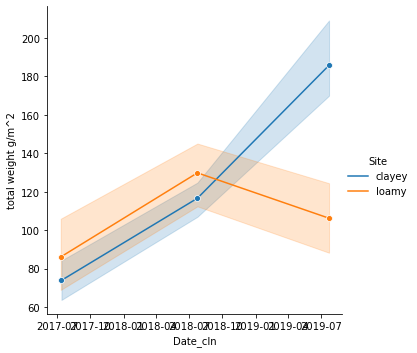

In [14]:
# plot pin-frame calibration data
sns.relplot(x='Date_cln', y='total weight g/m^2', hue='Site',
            data=df_pvs_bm, kind='line', marker="o")

# Pin Frame Dataset

### Combine Biomass and Pin Frame datasets

In [15]:
# drop 'loc' from plot data for consistency
df_pvs_pf['Plot Name'] = df_pvs_pf['Plot Name'].astype('str').apply(lambda x: int(re.sub('loc', '', x)))

# Create a new column in the Pin Frame dataframe pulling the nearest Biomass sampling date
df_pvs_pf = pd.merge_asof(df_pvs_pf.sort_values('Date'), 
                          df_pvs_bm.groupby(['Date_cln', 'Site', 'Plot Name']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                                                                                             'Plot Name',
                                                                                                                             'C4 weight g/m^2',
                                                                                                                             'C3 weight g/m^2', 
                                                                                                                             'forb weight g/m^2', 
                                                                                                                             'annual grass weight g/m^2', 
                                                                                                                             'SD weight g/m^2',
                                                                                                                             'total weight g/m^2',
                                                                                                                             'Date_cln']],
                          left_on='Date',
                          right_on='Date_cln',
                          by=['Site', 'Plot Name'],
                          direction='nearest',
                          tolerance=datetime.timedelta(days=15),
                          suffixes=['_x', ''])

In [24]:
# drop any records missing Biomass data
df_pvs_pf = df_pvs_pf[df_pvs_pf['total weight g/m^2'].notnull()]

### Clean up Pin Frame dataset

In [25]:
# drop basal hits
df_pvs_pf = df_pvs_pf[df_pvs_pf['Position'] != 'basal']

In [26]:
# calculate forb hits
df_pvs_pf['Forb'] = df_pvs_pf['AnnualForb'] + df_pvs_pf['PerennialForb']

# calculate annual grass hits
df_pvs_pf['Annual Grass'] = df_pvs_pf['Brome'] + df_pvs_pf['VUOC']

### Calculate appropriate values at the experimental unit level

In [33]:
# aggregate data by experimental unit
df_pvs_pf_agg = df_pvs_pf.groupby(
    ['Site', 'Plot Name', 'Date_cln']).aggregate(
    {'Total Hits': np.sum,
     'C4P_Grass': np.sum,
     'C3P_Grass': np.sum,
     'Annual Grass': np.sum,
     'Forb': np.sum,
     'StandingDead': np.sum,
     'TotalHerbHits': np.sum,
     'total weight g/m^2': np.mean,
     'C4 weight g/m^2': np.mean,
     'C3 weight g/m^2': np.mean,
     'forb weight g/m^2': np.mean,
     'annual grass weight g/m^2': np.mean,
     'SD weight g/m^2': np.mean}).reset_index()

In [34]:
pf_colname_mapper = {
    'C4P_Grass': 'hits_C4',
    'C3P_Grass': 'hits_C3',
    'Annual Grass': 'hits_AnnGrass',
    'Forb': 'hits_Forb',
    'StandingDead': 'hits_SD',
    'TotalHerbHits': 'hits_Total',
    'C4 weight g/m^2': 'weight_C4',
    'C3 weight g/m^2': 'weight_C3',
    'annual grass weight g/m^2': 'weight_AnnGrass',
    'forb weight g/m^2': 'weight_Forb',
    'SD weight g/m^2': 'weight_SD',
    'total weight g/m^2': 'weight_Total'
}

df_pvs_pf_agg = df_pvs_pf_agg.rename(columns=pf_colname_mapper)

In [35]:
# reset the year column
df_pvs_pf_agg['Year'] = df_pvs_pf_agg['Date_cln'].dt.year

# rename date column
df_pvs_pf_agg = df_pvs_pf_agg.rename(columns={'Date_cln': 'Date'})

### Create long-form version of data

In [36]:
# convert to long format to be able to plot with hue as the FG
df_pvs_pf_agg_long = pd.wide_to_long(df_pvs_pf_agg.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Plot Name', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

### Check data and save to disk

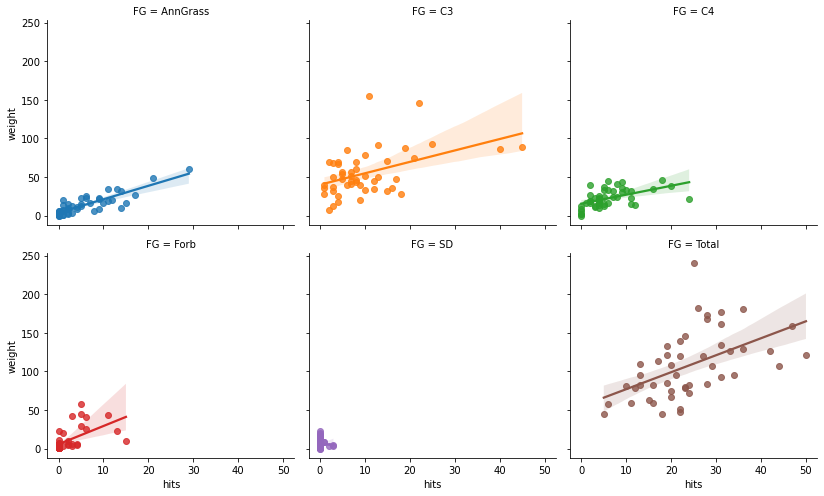

In [37]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='FG',
           data=df_pvs_pf_agg_long,
           scatter=True, height=3.5, aspect=1.1)

In [38]:
# explore outliers
df_pvs_pf_agg[(df_pvs_pf_agg.hits_C3 < 25) & (df_pvs_pf_agg.weight_C3 > 100)]

,Site,Plot Name,Date,Total Hits,hits_C4,hits_C3,hits_AnnGrass,hits_Forb,hits_SD,hits_Total,weight_Total,weight_C4,weight_C3,weight_Forb,weight_AnnGrass,weight_SD,Year
2,clayey,1,2019-07-23,25.0,2.0,11.0,6.0,6.0,0.0,25.0,240.90,16.8,155.40,40.90,22.60,5.20,2019
45,loamy,10,2017-07-11,28.0,6.0,22.0,0.0,0.0,0.0,28.0,167.24,16.0,145.86,1.68,2.02,1.68,2017


In [40]:
# drop meaningless columns
df_pvs_pf_agg_long = df_pvs_pf_agg_long.drop(columns=['index'])
# save datasets to disk
df_pvs_pf_agg.to_csv('data/TB_pvsage_pf.csv', index=False)
df_pvs_pf_agg_long.to_csv('data/TB_pvsage_pf_long.csv', index=False)

# Questions:
* Why is SD weight the sum of form weights for 2017?
  * email Katie
  * Also ask about Sub-shrub weights [YUGL, AGGL, ARFR, ARPE, GUSA, OOMU]
 
* What do 'C4+ forb', etc. mean in the clipping data?